# Image Segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007470.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008700.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_010320.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_007170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_006690_P.png')]

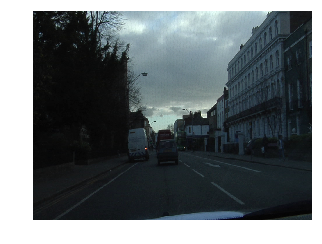

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [12]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

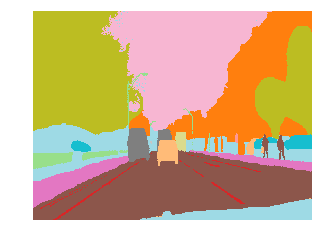

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [15]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [16]:
size = src_size//2
bs=8

In [19]:
src = (ImageFileList.from_folder(path_img)
      .label_from_func(get_y_fn)
      .split_by_fname_file('../valid.txt'))

In [14]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

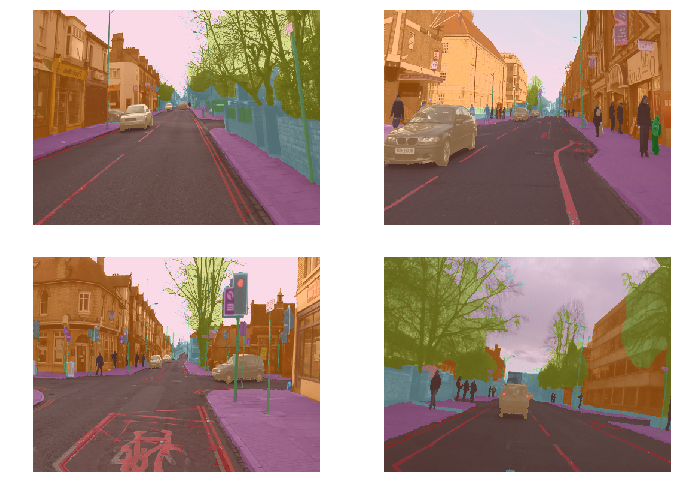

In [15]:
data.show_batch(2, figsize=(10,7))

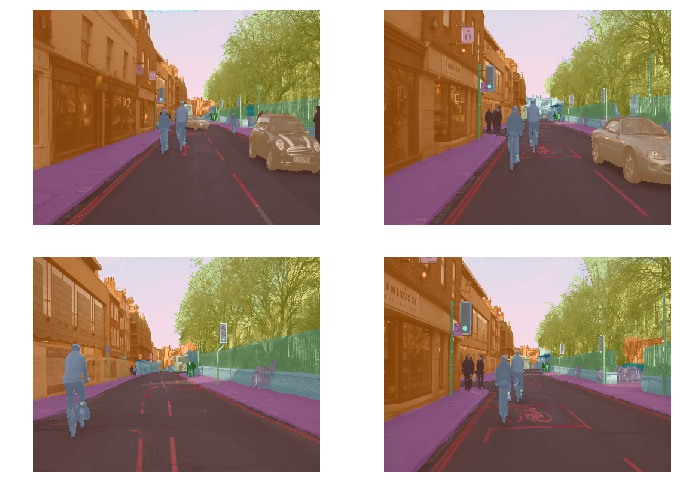

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [23]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
metrics=acc_camvid

In [19]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


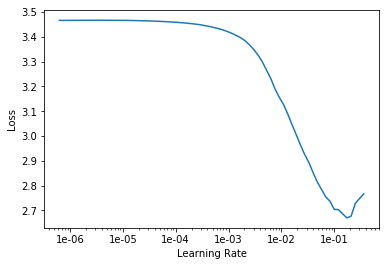

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=1e-2

In [22]:
learn.fit_one_cycle(10, slice(lr))

Total time: 05:01
epoch  train_loss  valid_loss  acc_camvid
1      1.647334    1.216840    0.804351    (00:33)
2      0.939717    0.667625    0.815959    (00:29)
3      0.729744    0.557843    0.856188    (00:29)
4      0.656052    0.517648    0.852875    (00:29)
5      0.579757    0.453084    0.865385    (00:29)
6      0.536753    0.395575    0.883074    (00:29)
7      0.484086    0.385611    0.877559    (00:29)
8      0.439569    0.360819    0.888917    (00:29)
9      0.407558    0.325849    0.901246    (00:30)
10     0.391579    0.319940    0.904650    (00:29)



In [23]:
learn.save('stage-1')

In [24]:
learn.load('stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f44e42560b8>, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn

In [25]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


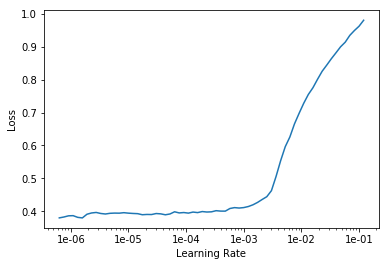

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lrs = slice(1e-5, lr/5)

In [28]:
learn.fit_one_cycle(12, lrs)

Total time: 06:49
epoch  train_loss  valid_loss  acc_camvid
1      0.390647    0.329818    0.900852    (00:33)
2      0.385236    0.331041    0.906485    (00:34)
3      0.389418    0.361643    0.890258    (00:34)
4      0.391042    0.308365    0.909839    (00:34)
5      0.386843    0.320834    0.910011    (00:34)
6      0.381274    0.298270    0.916269    (00:34)
7      0.354993    0.296073    0.916102    (00:34)
8      0.342933    0.292172    0.917383    (00:34)
9      0.327762    0.296092    0.916763    (00:34)
10     0.316200    0.280285    0.920785    (00:34)
11     0.306404    0.288929    0.919590    (00:34)
12     0.301516    0.285394    0.919517    (00:34)



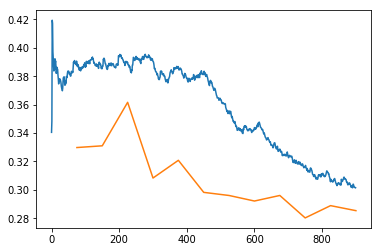

In [29]:
learn.recorder.plot_losses()

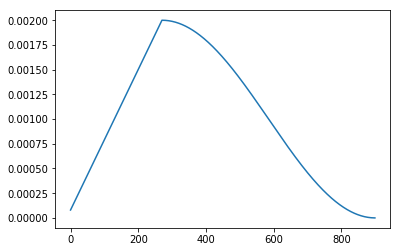

In [30]:
learn.recorder.plot_lr()

In [31]:
learn.save('stage-2')

## Go Big: Increase Images to Full Size

In [17]:
size = src_size
bs=2

In [20]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [25]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [26]:
learn.load('stage-2');

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


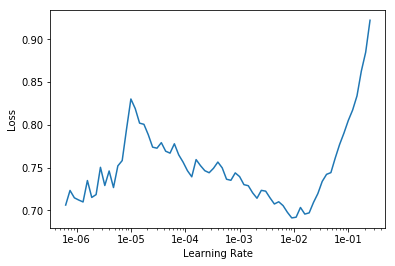

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr=1e-3

In [29]:
learn.fit_one_cycle(10, slice(lr))

Total time: 17:51
epoch  train_loss  valid_loss  acc_camvid
1      0.510226    0.349207    0.905720    (01:49)
2      0.430862    0.320882    0.913566    (01:46)
3      0.423418    0.335977    0.901398    (01:47)
4      0.406666    0.352409    0.905622    (01:46)
5      0.359027    0.306904    0.916404    (01:46)
6      0.352873    0.330459    0.904567    (01:46)
7      0.328804    0.293463    0.921094    (01:47)
8      0.323890    0.290035    0.920666    (01:46)
9      0.321351    0.295713    0.919652    (01:47)
10     0.300288    0.298803    0.917733    (01:46)



In [30]:
learn.save('stage-1-big')

In [32]:
learn.load('stage-1-big');

In [33]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


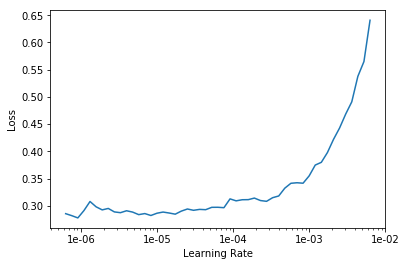

In [34]:
lr_find(learn)
learn.recorder.plot()

In [35]:
lrs = slice(1e-6,lr)

In [36]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 20:37
epoch  train_loss  valid_loss  acc_camvid
1      0.323929    0.289337    0.917782    (02:02)
2      0.337636    0.305438    0.916165    (02:03)
3      0.339247    0.293801    0.918878    (02:03)
4      0.317699    0.297692    0.913489    (02:03)
5      0.318384    0.276864    0.924045    (02:03)
6      0.294496    0.281001    0.922975    (02:03)
7      0.272269    0.279483    0.921321    (02:03)
8      0.270400    0.285907    0.920643    (02:03)
9      0.251784    0.274998    0.923422    (02:04)
10     0.251432    0.277926    0.923628    (02:04)



In [37]:
learn.save('stage-2-big')

In [39]:
learn.load('stage-2-big');

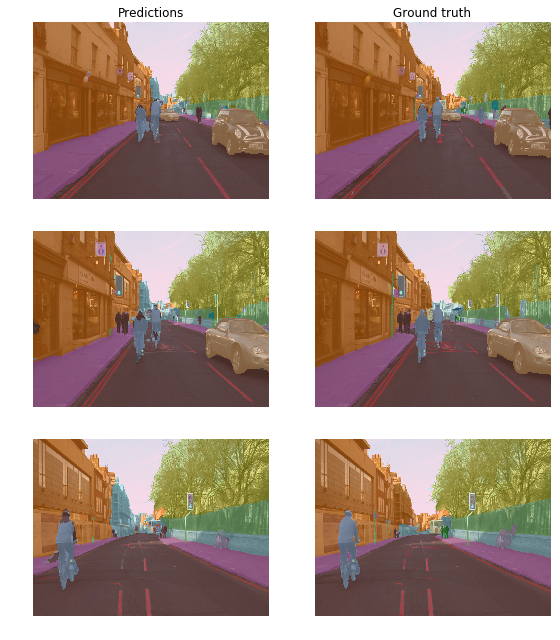

In [40]:
learn.show_results()